# Feature selection

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import missingno as msno
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

from ptbxl.utils.paths import data_processed_dir

sns.set_theme()


## Load data

In [34]:
# Leads names
leads = ['I', 'II', 'III', 'aVF', 'aVR',
         'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
feature_columns = ['DF_' + lead for lead in leads]

# The 'height', 'weight' atributes are excluded as they have a lot of missing values
demographic_columns = ['age', 'sex'] 
target_column = 'target'

In [35]:
dataset = pd.read_csv(data_processed_dir('dominant_freq_dataset.csv'))
dataset = dataset.set_index('ecg_id')
dataset = dataset.drop(['patient_id'], axis=1)

dataset = dataset[[target_column] + demographic_columns + feature_columns]
dataset[target_column] = dataset[target_column].astype(int)

print(f'Number of samples: {len(dataset)}')
display(dataset.head())

Number of samples: 9553


,target,age,sex,DF_I,DF_II,DF_III,DF_aVF,DF_aVR,DF_aVL,DF_V1,DF_V2,DF_V3,DF_V4,DF_V5,DF_V6
ecg_id,,,,,,,,,,,,,,,
17,1,56.0,0,2.375,2.375,2.375,2.375,2.375,0.125,2.375,2.375,2.375,2.375,2.375,2.375
18,1,56.0,0,2.125,2.125,0.125,2.125,2.125,0.125,2.125,2.125,2.125,2.125,2.125,2.125
20,1,56.0,0,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375
23,1,56.0,0,2.125,2.125,2.125,2.125,2.125,4.250,2.125,2.125,2.125,2.125,2.125,2.125
34,1,56.0,0,2.250,2.250,0.250,2.250,2.250,0.250,2.250,2.250,2.250,2.250,2.250,2.250


## Target variable distribution

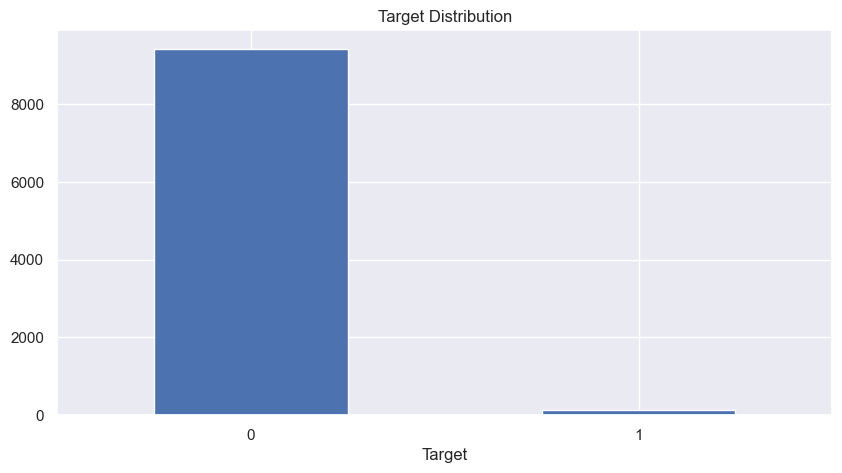

In [36]:
target_counts = dataset[target_column].value_counts()
plt.figure(figsize=(10, 5))
target_counts.plot(kind='bar')
plt.title('Target Distribution')
plt.xlabel('Target')
plt.xticks(rotation=0)
plt.show()

When dealing with imbalanced datasets in XGBoost, the scale_pos_weight parameter is useful for handling class imbalance by assigning more weight to the minority class in the loss function. This makes the model more sensitive to the positive class, which is underrepresented in the dataset.

The scale_pos_weight parameter is typically set to the ratio of the negative class samples to the positive class samples. This weight tells the classifier to give more importance to the minority class calculated as follows:

$$
\text{scale pos weight} = \frac{\text{number of negative samples}}{\text{number of positive samples}}
$$

In [37]:
scale_pos_weight = np.round(target_counts[0] / target_counts[1], 2)

## Feature analysis

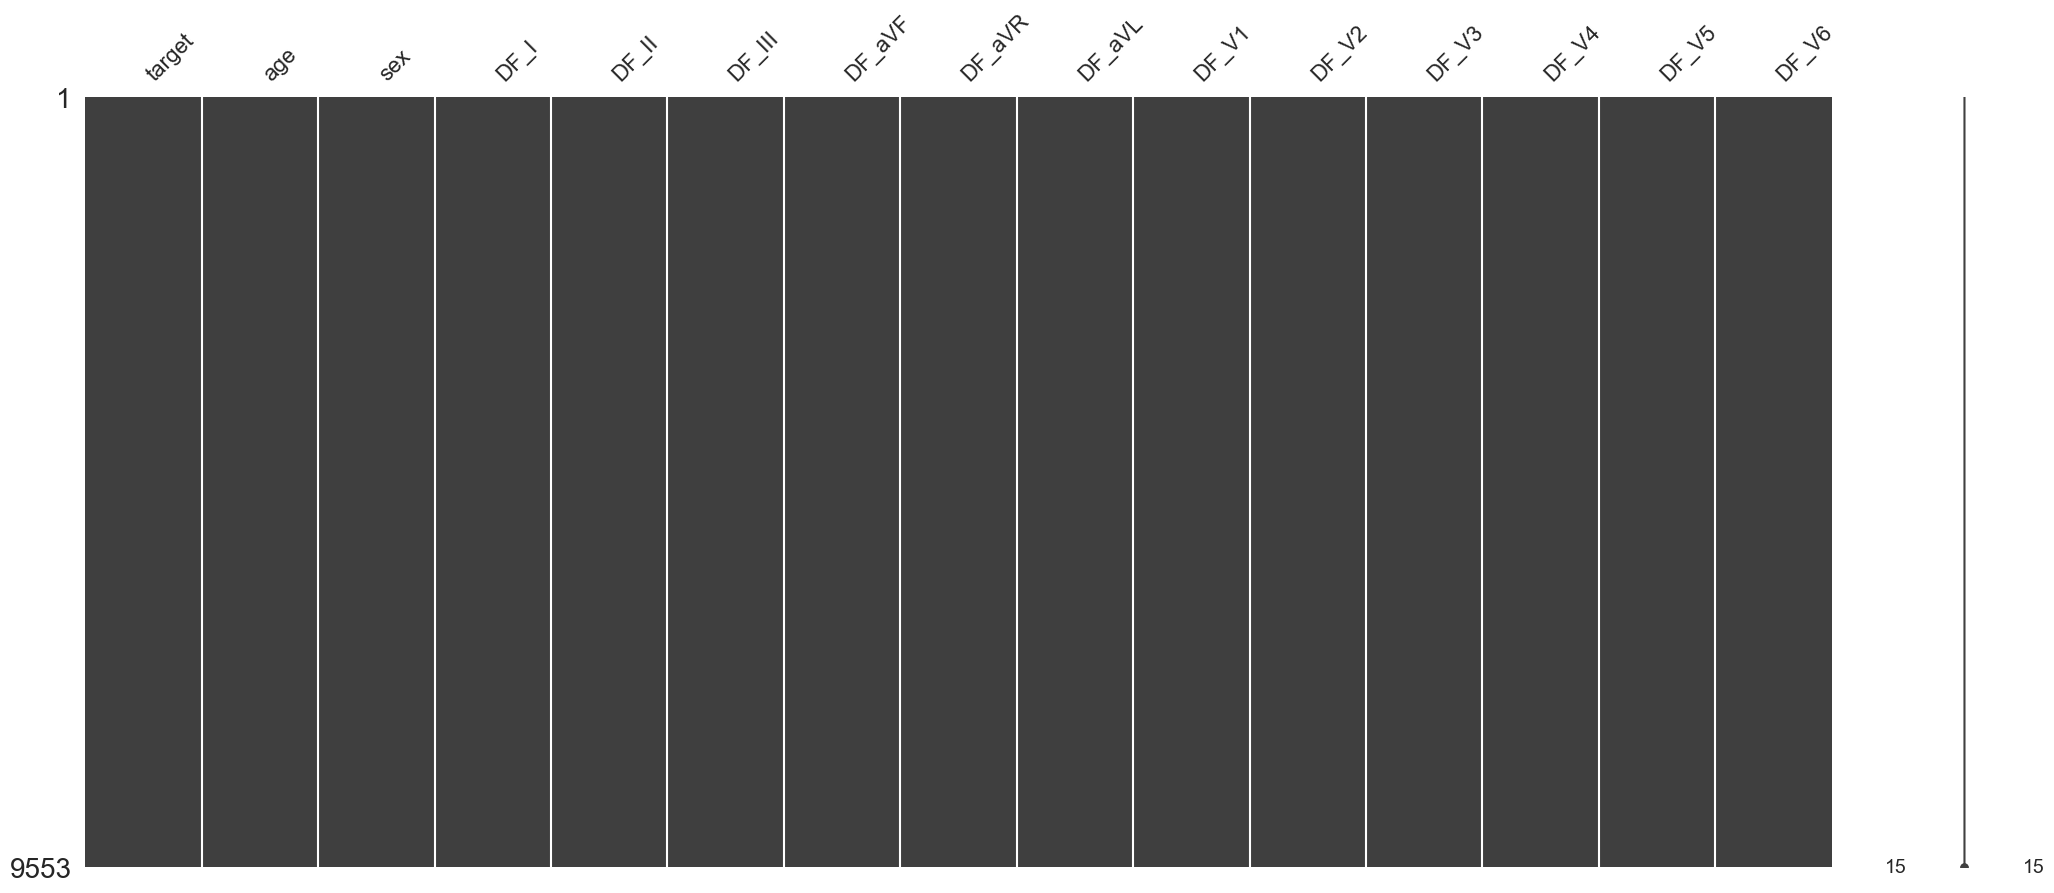

In [38]:
msno.matrix(dataset)
plt.show()

### Correlation matrix

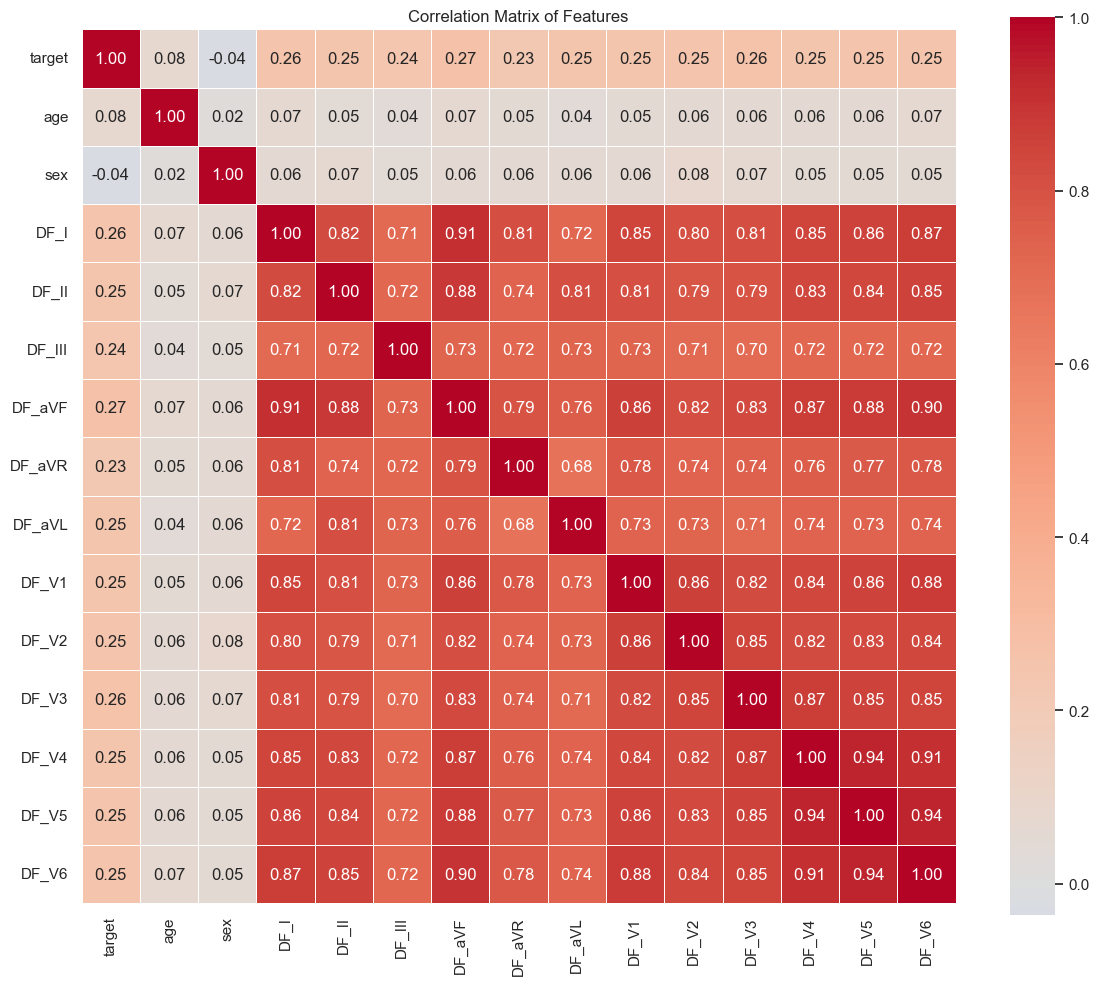

In [39]:
# Calculate correlation matrix
correlation_matrix = dataset.corr()

# Create a larger figure
plt.figure(figsize=(12, 10))

# Create heatmap with seaborn
sns.heatmap(
    correlation_matrix, 
    annot=True,  # Show correlation values
    cmap='coolwarm',  # Color scheme
    center=0,  # Center the colormap at 0
    square=True,  # Make cells square
    fmt='.2f',  # Format correlation values to 2 decimal places
    linewidths=0.5 # Add grid lines
)

plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.show()

When working with 12-lead ECG data, we can see high correlation among the leads, as they capture related information from different anatomical perspectives of the heart. This redundancy can be reduced by selecting a subset of the most informative leads, especially if the goal is feature extraction or model efficiency. Here are some strategies and insights into commonly used leads:

### Leads Most Commonly Used in ECG Analysis
   - In clinical and research settings, certain leads are often considered more informative for specific types of analysis:
     - **Lead II**: This lead is widely used because it often has the clearest QRS complexes and is commonly monitored in long-term and ambulatory ECG recordings.
     - **V1 and V5**: These precordial (chest) leads provide information on the anterior and lateral walls of the heart, respectively. They are commonly analyzed together as they offer different perspectives on cardiac activity.
     - **Lead I**: Lead I, along with Lead II, is often considered for rhythm analysis as it provides a good balance in terms of amplitude and morphology clarity.
   - **Recommended Selection**: If selecting only a few leads, **Lead II, V1, and V5** are generally a good starting point, as they provide a wide view of the heart's activity.

In [46]:
# Get recommended features
X = dataset[demographic_columns + ['DF_II', 'DF_V1', 'DF_V5']]
y = dataset[target_column]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# Apply xgboost
model = XGBClassifier(scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(f'F1-Score: {np.round(f1_score(y_test, y_pred), 2)}')
print(f'AUC-ROC: {np.round(roc_auc_score(y_test, y_pred), 2)}')

F1-Score: 0.32
AUC-ROC: 0.7


#### Compute confusion matrix

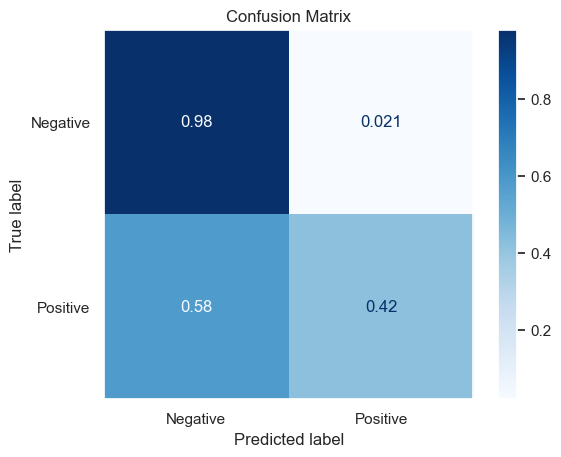

In [50]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")

plt.grid(False)
plt.show()

### Dimensionality Reduction Based on Lead Correlations
   - **Principal Component Analysis (PCA)**: Applying PCA to the 12-lead ECG features can help reduce dimensionality while retaining the most significant variance in the data. By transforming to a smaller set of components, we retain the dominant frequency information without relying on redundant leads.
   - **Correlation Analysis**: We've already observed high correlation among leads, so using correlation matrices to identify the most redundant leads is beneficial. Dropping leads that have a near-perfect correlation with others can help reduce the number of features without losing much information.

### Selecting Leads Based on Clinical Utility
   - Depending on the application (e.g., arrhythmia detection, ischemia analysis), some leads might be more relevant than others:
     - **Arrhythmia Detection**: Leads with prominent QRS complexes like **Lead II** and **V1** are beneficial.
     - **Ischemia or Myocardial Infarction Detection**: Including precordial leads **V3-V6** along with **Lead II** can be useful for identifying localized abnormalities in the heart muscle.

### Domain Knowledge for Reducing Leads
   - If there is domain-specific knowledge available (e.g., certain leads are known to show abnormalities for particular conditions), we can prioritize leads that experts in cardiology often focus on for diagnostic purposes.
   
### Suggested Subsets:
   - **Minimal Subset**: Use **Lead II** alone for general ECG feature extraction.
   - **Balanced Set**: Use **Lead II, V1, and V5** to cover different regions of the heart with minimal redundancy.
   - **Extended Set**: Use **Lead II, V1, V5, and I** for a broader view while still reducing the full 12-lead set. 

Using these leads as a basis for feature extraction, such as dominant frequency analysis, often provides adequate coverage while avoiding unnecessary redundancy.